# I would like to thank Mattia Ciollaro for providing the data and mentorship to continue my data journey. 

Purpose of this analysis: To explore different types of procedures performed at a hospital. 

Data Source: A clean (The data squeaks type of clean) data set of 1,463 hospitals and the number of surgical procedures they performed in 2016. 

Types of Procedures Performed: Gastrointestinal (GI), Eye, Nervous System, Musculoskeletal, Skin (Derm), Genitourinary, Cardiovascular, Respiratory, and Other. 

Note: The actual amount of procedures performed at a large health system (For Example: Mayo Clinic) is far more than what you might expect if you are coming from a non-healthcare background. To give perspective, Mayo Clinic general surgeons perform over 10,000 procedures annually: https://www.mayoclinic.org/departments-centers/general-surgery/overview

In [1]:
from os import path
import matplotlib.lines as ln
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

## Read data

In [2]:
HospitalProcedures = pd.read_csv("hospital_procedures_volumes.csv")

Each row is a hospital.

The columns provide counts of procedures performed at the given
hospital in the year 2016

## Let's Examine The Data

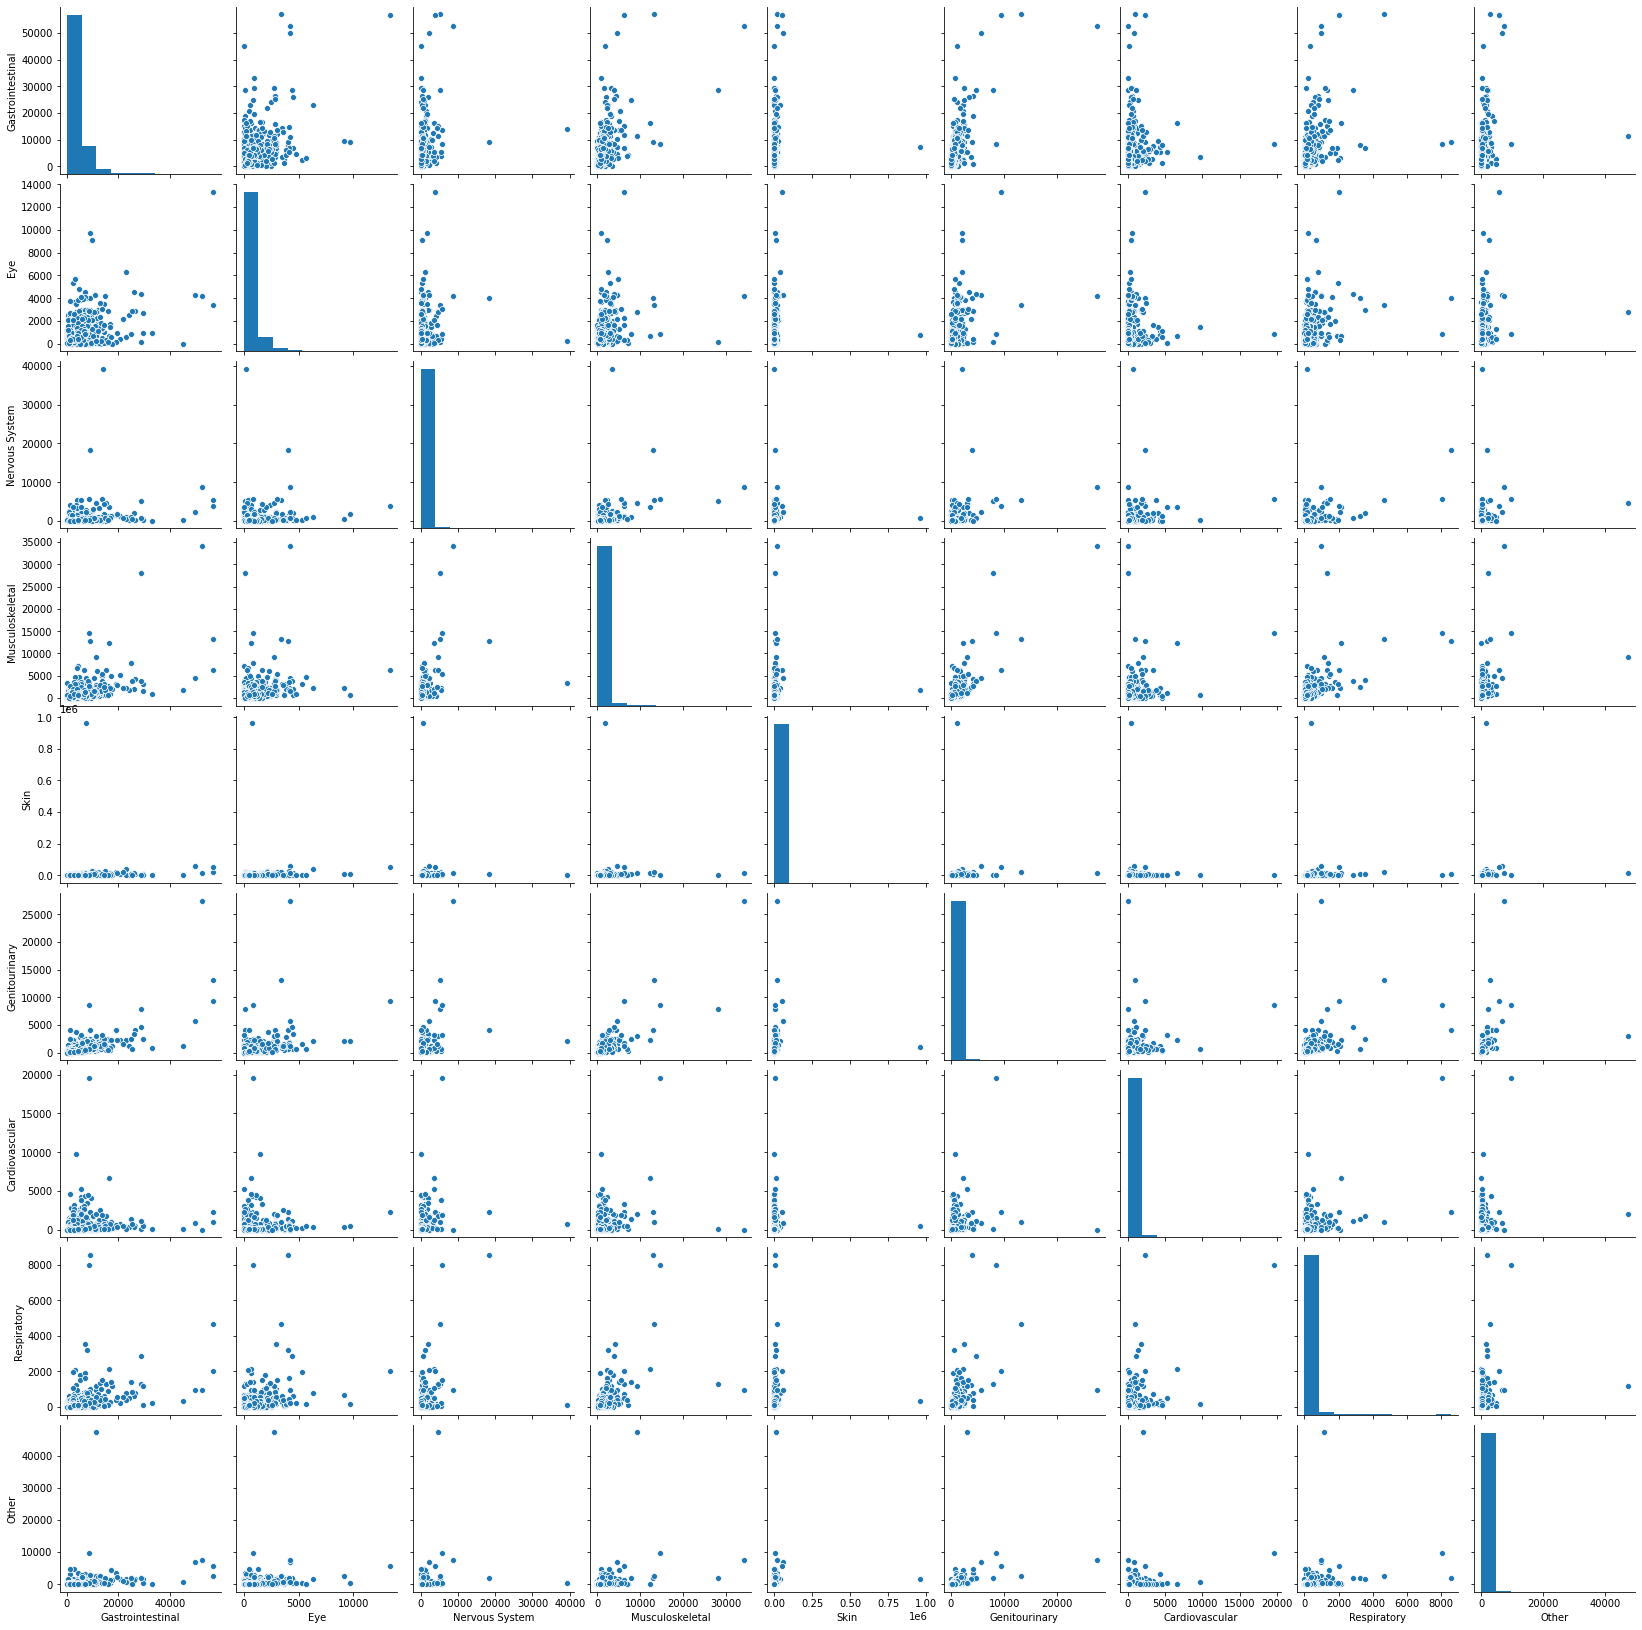

In [3]:
_plt = sns.pairplot(HospitalProcedures)

Seaborn (Denoted by the sns designation) pairplots allow you to read the data from left to right and check for associtions between the procedures.

The first set of pairplots has some skewness, so applying a log transformation should "correct" it.

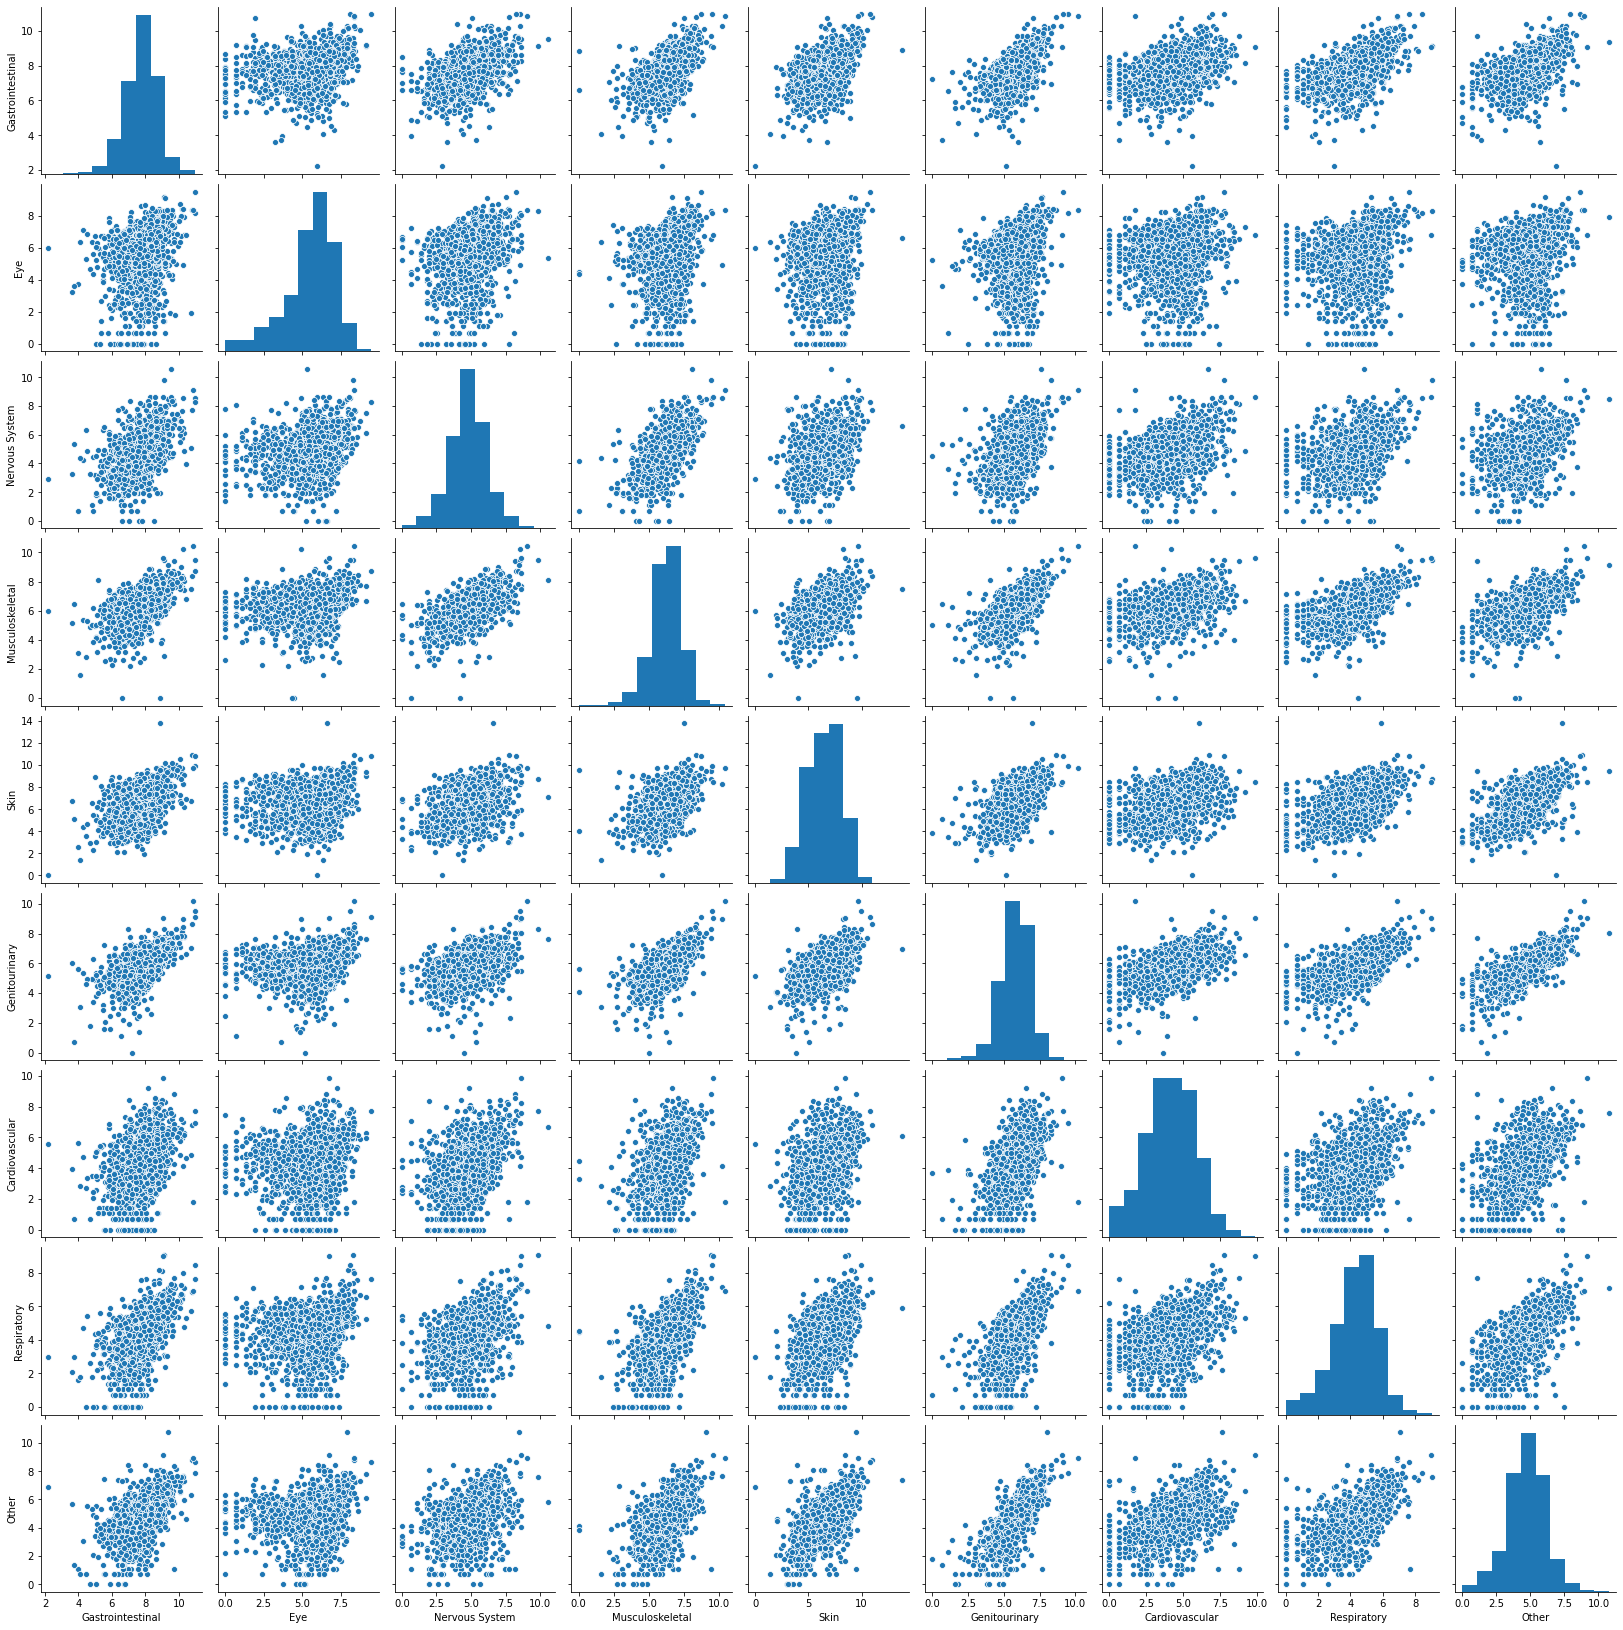

In [4]:
_plt = sns.pairplot(np.log(HospitalProcedures))

Looking at the pair plots after the log transformation, its interesting to see that a potential relationship exists between the volume of Gastrointestinal, Genitourinary, and Musculoskeletal procedures. 

Let's examine that a bit further in the next pair plot

Seaborn Pair Plot Documentation: https://seaborn.pydata.org/generated/seaborn.pairplot.html

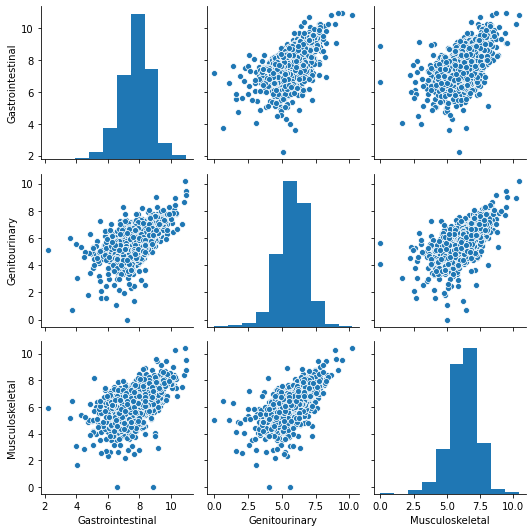

In [5]:
_plt = sns.pairplot(
    np.log(HospitalProcedures[
        ["Gastrointestinal", "Genitourinary", "Musculoskeletal"]
    ])
)
plt.tight_layout()

We can see that the counts of the above procedures are positively correlated. Let's take advantage of these correlations to build a predictive model. 

In case you were wondering, here is the full correlation matrix:

In [6]:
np.log(HospitalProcedures).corr()

,Gastrointestinal,Eye,Nervous System,Musculoskeletal,Skin,Genitourinary,Cardiovascular,Respiratory,Other
Gastrointestinal,1.000000,0.273242,0.488188,0.563213,0.469180,0.593920,0.384172,0.551406,0.521969
Eye,0.273242,1.000000,0.270040,0.233043,0.126126,0.176226,0.097935,0.190709,0.128830
Nervous System,0.488188,0.270040,1.000000,0.639709,0.339109,0.447444,0.415486,0.420631,0.364640
Musculoskeletal,0.563213,0.233043,0.639709,1.000000,0.469409,0.633061,0.433881,0.590303,0.593747
Skin,0.469180,0.126126,0.339109,0.469409,1.000000,0.515370,0.406639,0.484982,0.570308
Genitourinary,0.593920,0.176226,0.447444,0.633061,0.515370,1.000000,0.552054,0.628251,0.748685
Cardiovascular,0.384172,0.097935,0.415486,0.433881,0.406639,0.552054,1.000000,0.458652,0.538454
Respiratory,0.551406,0.190709,0.420631,0.590303,0.484982,0.628251,0.458652,1.000000,0.643636
Other,0.521969,0.128830,0.364640,0.593747,0.570308,0.748685,0.538454,0.643636,1.000000


### Make a version of the 'logged data' for future use

In [7]:
LoggedHospitalProcedures = np.log(HospitalProcedures)

We will use the log-counts of the other medical procedures to
develop a model that can help us predict the count of the
Gastrointestinal medical procedures at a given hospital.

In [8]:
X = sm.add_constant(LoggedHospitalProcedures.drop("Gastrointestinal", axis=1))

In [9]:
Y = HospitalProcedures["Gastrointestinal"]

In [10]:
log_Y = LoggedHospitalProcedures["Gastrointestinal"]

## Goal

Devlop a regression model to predict the number of yearly Gastrointestinal procedures at a given hospital given the number of procedures performed in a different medical specializations.

Two ways to go about performing Poisson Regression in Python: 
Method 1: The way shown below with statsmodels. Statsmodels Documentation: https://www.statsmodels.org/stable/index.html
Method 2: Via Scikit-Learn. Documentation for Poisson Regression in Scikit-Learn: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.PoissonRegressor.html

## Poisson Regression Model

Pick the `Poisson` regression model from the `statsmodels` module.

In [11]:
poisson_regression = sm.Poisson(Y, X)

In [12]:
poisson_regression_fit = poisson_regression.fit()

Optimization terminated successfully.
         Current function value: 685.234747
         Iterations 6


In [13]:
poisson_regression_pred = poisson_regression_fit.predict(X)

So we created a prediction. Let's plot it and see how it performed. 

Note: Great references for plots: https://jakevdp.github.io/PythonDataScienceHandbook/index.html
Example Plots with Code: https://matplotlib.org/stable/gallery/index.html#pyplot

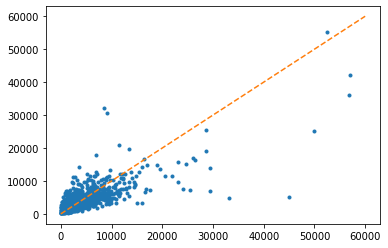

In [14]:
_plt = plt.plot(Y, poisson_regression_pred, ".")

# a little utility to add the bisector line
def add_bisector(xmin, xmax, ymin, ymax, **kwargs):
    _bisector = ln.Line2D(
        [xmin, xmax], [ymin, ymax],
        **kwargs
    )
    ax = plt.gca()
    _ = ax.add_line(_bisector)
    
add_bisector(0, 60000, 0, 60000, linestyle="--", color=sns.color_palette()[1])

Another skewed distribution. To better visualize the predictions, let's utilize a log-log coordinates system. 



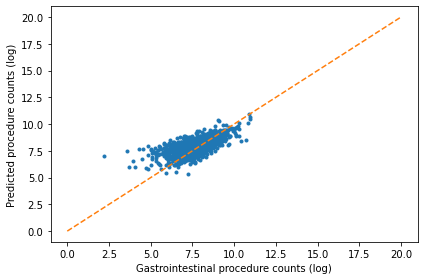

In [15]:
_plt = plt.plot(log_Y, np.log(poisson_regression_pred), ".")

# add the bisector line
add_bisector(0, 20, 0, 20, linestyle="--", color=sns.color_palette()[1])

# add titles and axis labels
ax = plt.gca()
ax.set_xlabel("Gastrointestinal procedure counts (log)")
ax.set_ylabel("Predicted procedure counts (log)")

plt.tight_layout()

Let's now compute the RMSE for our model. RMSE stands for Root Mean Square Error (RMSE): https://stats.stackexchange.com/questions/56302/what-are-good-rmse-values

In [16]:
def compute_rmse(y, y_pred):
    squared_residuals = np.square(y - y_pred)
    return np.sqrt(np.mean(squared_residuals))

In [17]:
poisson_regression_rmse = compute_rmse(
    HospitalProcedures["Gastrointestinal"], poisson_regression_pred
)

In [18]:
poisson_regression_rmse

3052.0095605946335

For comparison, what is the RMSE associated to the dummy
model that only uses the average "Gastrointestinal"
counts and none of the other available predictors?

In [19]:
# Note that this is simply the variance of the response variable
dummy_rmse = np.std(HospitalProcedures["Gastrointestinal"])

In [20]:
dummy_rmse

4665.03848056645

We are doing better than the dummy model, but how much better?

In [21]:
poisson_regression_rmse / dummy_rmse

0.6542303077045668

It looks like the model has a RMSE that is about 35%
lower that the RMSE corresponding to the dummy model
corresponding to the mean of the response variable.

Interpretation of the Model: Credit for the equations and text block goes to Mattia Ciollaro

### Interpretation of the model

We have fitted a model for $E(Y \mid X)$ by assuming that:

- $Y$ is Poisson distributed with expected value equal to $E(Y \mid X)$

- $E(Y \mid X) = \exp(\beta_0 + \beta_1 X_1 + \dots + \beta_p X_p)$

How can we interpret, e.g., $\beta_1$?

Well, by doing some little algebra, we see that

$E(Y \mid X_1 = x + 1, X_2, \dots, X_p) \quad / \quad E(Y \mid X_1 = x, X_2, \dots, X_p) = \exp(\beta_1$)

which means that $\exp(\beta_1)$ measures the relative variation
of the expected value of Y corresponding to a unit increase in $X_1$
(assuming that all other predictors are kept constant).

In [22]:
poisson_regression_fit.params

const              3.881848
Eye                0.054298
Nervous System     0.079036
Musculoskeletal    0.094404
Skin               0.071910
Genitourinary      0.328292
Cardiovascular    -0.011764
Respiratory        0.107771
Other              0.012123
dtype: float64

In [23]:
np.exp(poisson_regression_fit.params["Eye"])

1.0557987394578274

What the expression above is telling us is as follows: Each unit increase in the log of the Eye procedure count is associated to an estimated 5% increaes in the number of Gastrointestinal procedures.

## What We Already Know

Another approach that we could use is to perform a multiple
linear regression of the log-counts of the "Gastrointestinal"
procedures on the log-counts of the other procedures.

In fact, it looks like the log-transformed "Gastrointestinal"
counts are *approximately* Normally distributed.

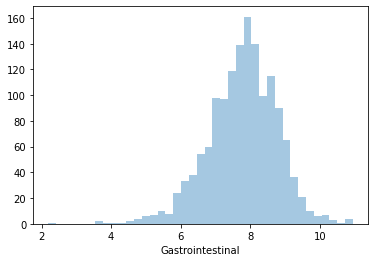

In [24]:
_ = sns.distplot(log_Y, kde=False)

In [25]:
linear_regression = sm.OLS(log_Y, X)

In [26]:
linear_regression_fit = linear_regression.fit()

In [27]:
linear_regression_pred = linear_regression_fit.predict(X)

In this case, don't forget that the model is trained to 
predict $\log Y$ and not $Y$!

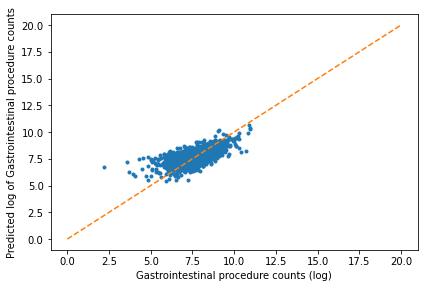

In [28]:
_plt = plt.plot(log_Y, linear_regression_pred, ".")

add_bisector(0, 20, 0, 20, linestyle="--", color=sns.color_palette()[1])

ax = plt.gca()
ax.set_xlabel("Gastrointestinal procedure counts (log)")
ax.set_ylabel("Predicted log of Gastrointestinal procedure counts")
plt.tight_layout()

What is the RMSE of this linear regression model?

In [29]:
linear_regression_rmse = compute_rmse(
    HospitalProcedures["Gastrointestinal"], np.exp(linear_regression_pred)
)

In [30]:
linear_regression_rmse

3257.5571006968353

The linear regression model seems to be outperformed by the
Poisson model by 6%-7%.

In [31]:
linear_regression_rmse / poisson_regression_rmse

1.067348262192912

### Interpretation of the model

This time we have fitted a model for $E(\log Y \mid X)$.

**Note that this is not a Generalized Linear Model for the response
variable $Y$!!!**

However, it is a linear regression for the response variable $Z=\log Y$ and
therefore a Generalized Linear Model for $Z$ (since linear regression models
are a subset of the family of GLMs).

This time, we assumed that:

- $\log Y$ is approximately Normally distributed with expected value equal to
  $E(\log Y \mid X)$

- $E(\log Y \mid X) = \beta_0 + \beta_1 X_1 + \dots + \beta_p X_p$

So, this time, how do we interpret, e.g., $\beta_1$?

Again, after some little algebra, we see that

$E(\log Y \mid X_1 = x + 1, X_2, \dots, X_p) - E(\log Y \mid X_1 = x, X_2, \dots, X_p) = \beta_1$

which means that $\beta_1$ measures the absolute variation
of the expected value of $\log Y$ corresponding to a unit increase in $X_1$
(assuming that all other predictors are kept constant).

In [32]:
linear_regression_fit.params

const              3.778556
Eye                0.065907
Nervous System     0.116710
Musculoskeletal    0.097207
Skin               0.083978
Genitourinary      0.242366
Cardiovascular    -0.015102
Respiratory        0.121340
Other              0.013898
dtype: float64

In [33]:
linear_regression_fit.params["Eye"]

0.06590675799068697

In this example, the Poisson model provided a better fit and an easier
interpretation of the coefficients.